<a href="https://colab.research.google.com/github/ReyhaneTaj/Data-Science-Practices/blob/main/Lendo_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task1 :** To construct a classification model to predict whether an applicant (after creating an application) receives payment.




In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

import pickle


***Task 0: Data Retrieval***

In [ ]:
def fetch_data(token, date_from, date_to):
    base_url = "https://sample-database-case-hholxbesyq-lm.a.run.app/applications"
    params = {
        'token': token,
        'dateFrom': date_from,
        'dateTo': date_to
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

date_from = datetime.strptime("2023-10-01", "%Y-%m-%d")
date_to = datetime.strptime("2023-10-14", "%Y-%m-%d")

all_data = []


token = "49c56f5c-0726-4f27-a333-5275390caa45"

while date_from <= datetime.strptime("2023-12-31", "%Y-%m-%d"):
    date_from_str = date_from.strftime("%Y-%m-%d")
    date_to_str = date_to.strftime("%Y-%m-%d")

    data = fetch_data(token, date_from_str, date_to_str)
    if data:
        print(f"Data fetched successfully for {date_from_str} to {date_to_str}")
        all_data.extend(data)
    else:
        print(f"Failed to fetch data for {date_from_str} to {date_to_str}")

    date_from += timedelta(days=14)
    date_to += timedelta(days=14)

df = pd.DataFrame(all_data)


Data fetched successfully for 2023-10-01 to 2023-10-14
Data fetched successfully for 2023-10-15 to 2023-10-28
Data fetched successfully for 2023-10-29 to 2023-11-11
Data fetched successfully for 2023-11-12 to 2023-11-25
Data fetched successfully for 2023-11-26 to 2023-12-09
Data fetched successfully for 2023-12-10 to 2023-12-23
Data fetched successfully for 2023-12-24 to 2024-01-06


**Task 1: Data Preprocessing and Model Training**

In [ ]:
df.head()

,APPLICATION_ID,REVISION,APPLICATION_DATE,APPLIED_AMOUNT,ACCEPTED_INTEREST_RATE,REFINANCE,AMORTIZATION_LENGTH,HAS_CO_APPLICANT,AGE,NUMBER_OF_CHILDREN,CIVIL_STATE,ACCOMMODATION_TYPE,EMPLOYMENT_TYPE,MONTHLY_INCOME,PAID_OUT_BANK,PAID_APPLICATION
0,a5c7e442-71c1-5c9b-b034-294e5bc3424e,1,2023-10-12,0.075000,NaN,0,60,0,0.866667,0.0,single,house,pension,0.054545,None,0
1,359e7f8b-bf24-5038-8d8c-47e3c36b5b07,1,2023-10-10,0.016667,NaN,0,12,0,0.477778,2.0,single,condominium,full_time,0.116667,None,0
2,e0030aae-8e13-5f84-9549-4287c10e58dc,1,2023-10-02,0.166667,0.394681,0,12,0,0.633333,2.0,married,house,full_time,1.000000,Emerald City Bank,1
3,688b6478-5932-5a35-b564-b85e05430990,1,2023-10-03,0.666667,NaN,1,144,0,0.466667,0.0,married,rental,full_time,0.307692,None,0
4,db54c591-4eb0-5afc-ab68-5c01c6acb2c4,1,2023-10-14,0.166667,0.274486,1,48,0,0.433333,2.0,live_together,house,full_time,0.081818,Crimson Capital,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117577 entries, 0 to 117576
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_ID          117577 non-null  object 
 1   REVISION                117577 non-null  int64  
 2   APPLICATION_DATE        117577 non-null  object 
 3   APPLIED_AMOUNT          117577 non-null  float64
 4   ACCEPTED_INTEREST_RATE  43649 non-null   float64
 5   REFINANCE               117577 non-null  int64  
 6   AMORTIZATION_LENGTH     117577 non-null  int64  
 7   HAS_CO_APPLICANT        117577 non-null  int64  
 8   AGE                     117577 non-null  float64
 9   NUMBER_OF_CHILDREN      117458 non-null  float64
 10  CIVIL_STATE             117577 non-null  object 
 11  ACCOMMODATION_TYPE      117577 non-null  object 
 12  EMPLOYMENT_TYPE         109344 non-null  object 
 13  MONTHLY_INCOME          117577 non-null  float64
 14  PAID_OUT_BANK       

In [ ]:
# Set the 'APPLICATION_ID' column as the index for easy identification of each application
df.set_index('APPLICATION_ID', inplace=True)

<ipython-input-6-b69e3e2790ec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='PAID_APPLICATION', data=df, palette='Set2')


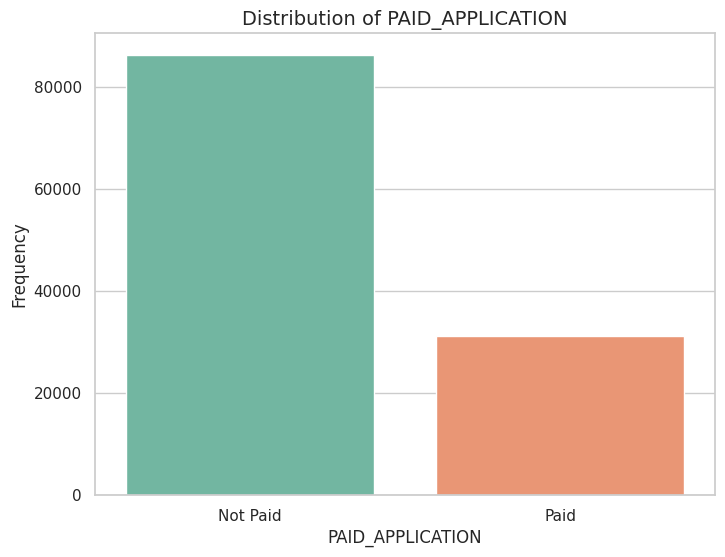

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='PAID_APPLICATION', data=df, palette='Set2')
plt.xlabel('PAID_APPLICATION', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of PAID_APPLICATION', fontsize=14)
plt.xticks([0, 1], ['Not Paid', 'Paid'])
plt.show()


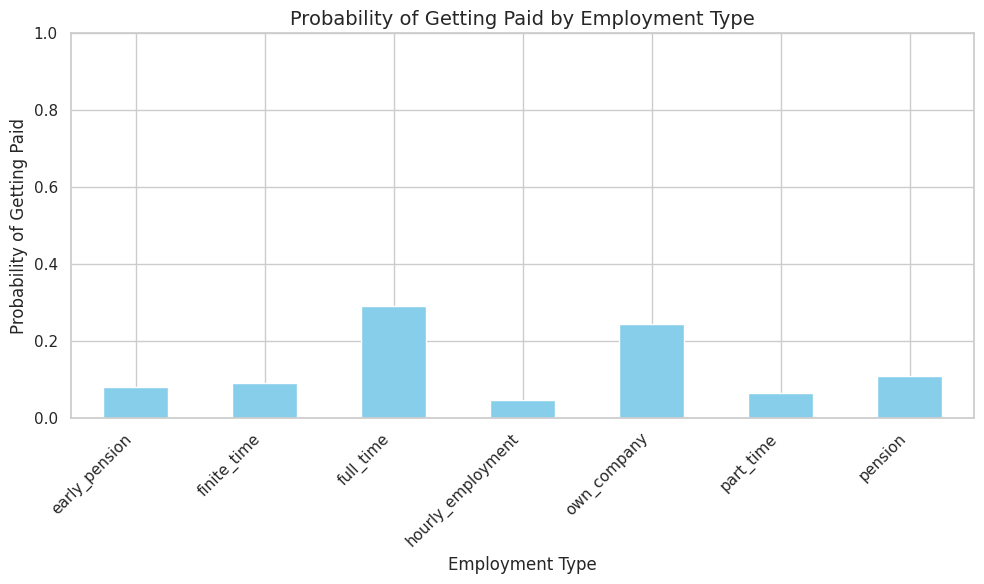

In [ ]:
# Calculate the probability of getting paid for each job type
paid_prob_by_job = df.groupby('EMPLOYMENT_TYPE')['PAID_APPLICATION'].mean()

plt.figure(figsize=(10, 6))
paid_prob_by_job.plot(kind='bar', color='skyblue')
plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Probability of Getting Paid', fontsize=12)
plt.title('Probability of Getting Paid by Employment Type', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


<ipython-input-8-2224ff1c69ff>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='PAID_OUT_BANK', data=df[df['PAID_APPLICATION'] == 1], palette='Set2')


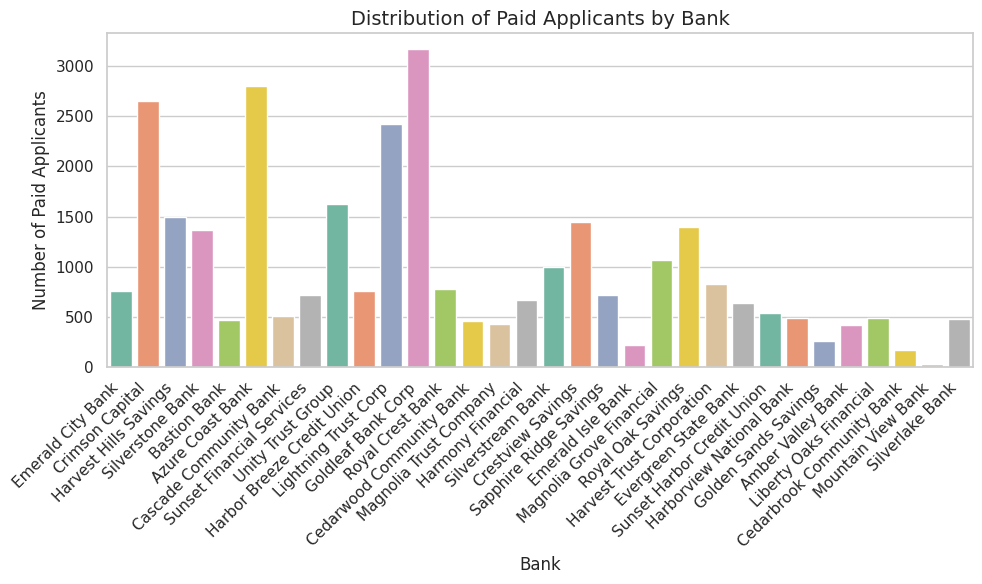

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PAID_OUT_BANK', data=df[df['PAID_APPLICATION'] == 1], palette='Set2')
plt.xlabel('Bank', fontsize=12)
plt.ylabel('Number of Paid Applicants', fontsize=12)
plt.title('Distribution of Paid Applicants by Bank', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
def count_unique_values_and_types(df):
    """
    Counting unique values

    Parameters
    ----------
      df: Pandas DataFrame

    Return
    ------
      print the number of unique values
    """
    for column in df.columns:
        unique_values_count = df[column].nunique()
        data_type = df[column].dtype
        print(f"Column '{column}' has {unique_values_count} {data_type} unique values.")


count_unique_values_and_types(df)

Column 'REVISION' has 10 int64 unique values.
Column 'APPLICATION_DATE' has 92 object unique values.
Column 'APPLIED_AMOUNT' has 214 float64 unique values.
Column 'ACCEPTED_INTEREST_RATE' has 13873 float64 unique values.
Column 'REFINANCE' has 2 int64 unique values.
Column 'AMORTIZATION_LENGTH' has 15 int64 unique values.
Column 'HAS_CO_APPLICANT' has 2 int64 unique values.
Column 'AGE' has 189 float64 unique values.
Column 'NUMBER_OF_CHILDREN' has 4 float64 unique values.
Column 'CIVIL_STATE' has 4 object unique values.
Column 'ACCOMMODATION_TYPE' has 4 object unique values.
Column 'EMPLOYMENT_TYPE' has 7 object unique values.
Column 'MONTHLY_INCOME' has 483 float64 unique values.
Column 'PAID_OUT_BANK' has 32 object unique values.
Column 'PAID_APPLICATION' has 2 int64 unique values.


In [ ]:
# Transform all categorical columns with numerical values
label_encoder = LabelEncoder()
for col in ['CIVIL_STATE', 'ACCOMMODATION_TYPE', 'EMPLOYMENT_TYPE', 'PAID_OUT_BANK']:
    df[col] = label_encoder.fit_transform(df[col])


df.head()

,REVISION,APPLICATION_DATE,APPLIED_AMOUNT,ACCEPTED_INTEREST_RATE,REFINANCE,AMORTIZATION_LENGTH,HAS_CO_APPLICANT,AGE,NUMBER_OF_CHILDREN,CIVIL_STATE,ACCOMMODATION_TYPE,EMPLOYMENT_TYPE,MONTHLY_INCOME,PAID_OUT_BANK,PAID_APPLICATION
APPLICATION_ID,,,,,,,,,,,,,,,
a5c7e442-71c1-5c9b-b034-294e5bc3424e,1,2023-10-12,0.075000,NaN,0,60,0,0.866667,0.0,3,1,6,0.054545,32,0
359e7f8b-bf24-5038-8d8c-47e3c36b5b07,1,2023-10-10,0.016667,NaN,0,12,0,0.477778,2.0,3,0,2,0.116667,32,0
e0030aae-8e13-5f84-9549-4287c10e58dc,1,2023-10-02,0.166667,0.394681,0,12,0,0.633333,2.0,2,1,2,1.000000,8,1
688b6478-5932-5a35-b564-b85e05430990,1,2023-10-03,0.666667,NaN,1,144,0,0.466667,0.0,2,2,2,0.307692,32,0
db54c591-4eb0-5afc-ab68-5c01c6acb2c4,1,2023-10-14,0.166667,0.274486,1,48,0,0.433333,2.0,1,1,2,0.081818,7,1


In [ ]:
df['APPLICATION_DATE'] = pd.to_datetime(df['APPLICATION_DATE'])

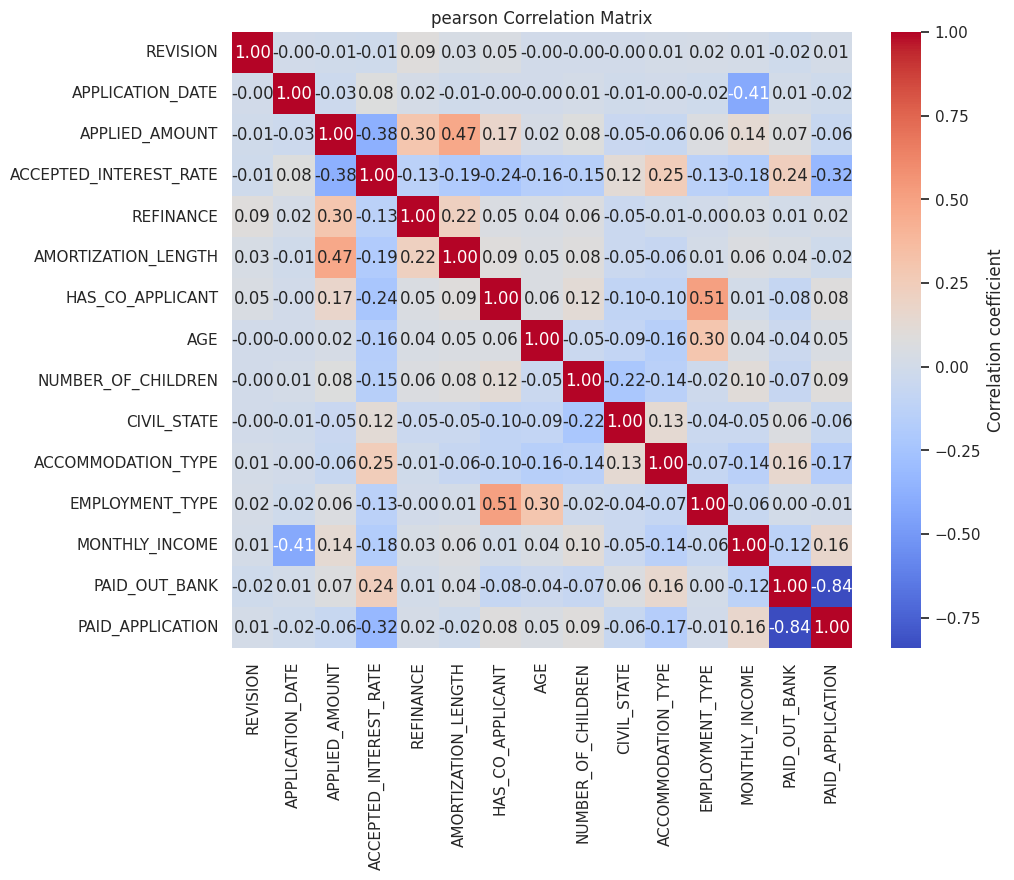

Correlation with target variable (PAID_APPLICATION):
PAID_APPLICATION          1.000000
MONTHLY_INCOME            0.161943
NUMBER_OF_CHILDREN        0.086571
HAS_CO_APPLICANT          0.080021
AGE                       0.048387
REFINANCE                 0.016380
REVISION                  0.009000
EMPLOYMENT_TYPE          -0.006303
APPLICATION_DATE         -0.016026
AMORTIZATION_LENGTH      -0.018912
APPLIED_AMOUNT           -0.058537
CIVIL_STATE              -0.063441
ACCOMMODATION_TYPE       -0.171745
ACCEPTED_INTEREST_RATE   -0.324467
PAID_OUT_BANK            -0.841315
Name: PAID_APPLICATION, dtype: float64


In [ ]:
correlation_matrix_pearson = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pearson, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('pearson Correlation Matrix')
plt.show()


print("Correlation with target variable (PAID_APPLICATION):")
print(correlation_matrix_pearson['PAID_APPLICATION'].sort_values(ascending=False))

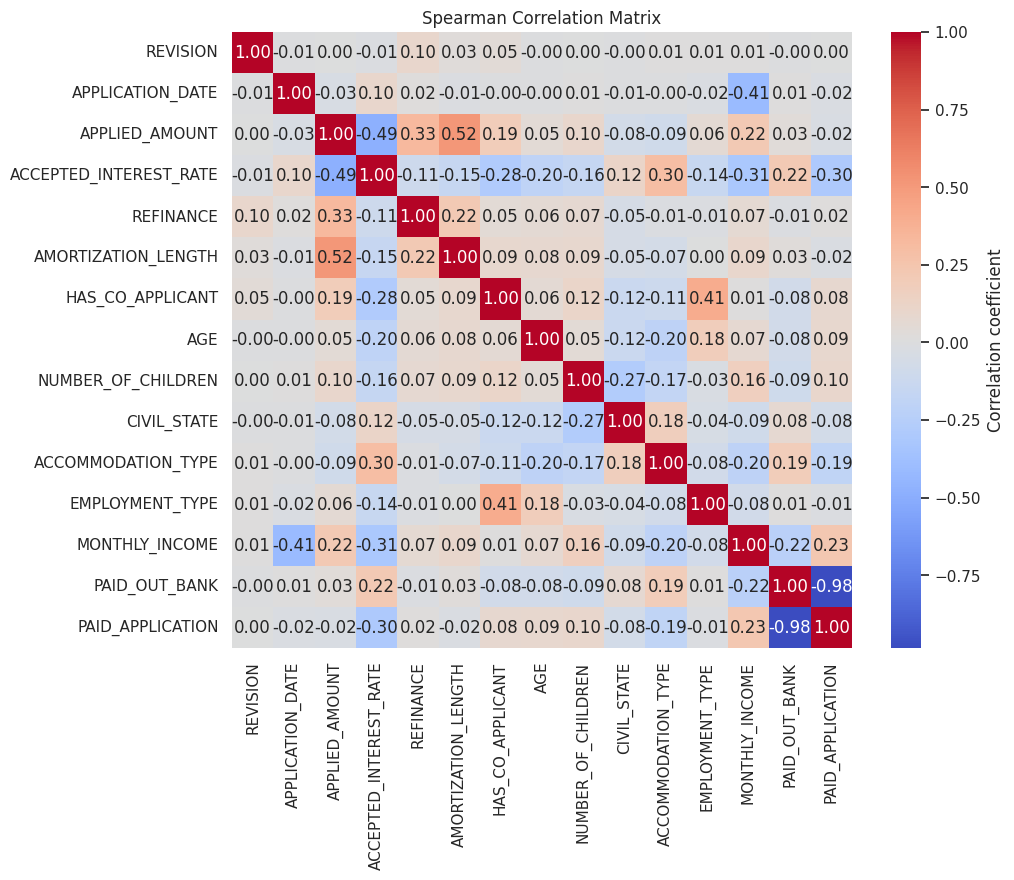

Correlation with target variable (PAID_APPLICATION):
PAID_APPLICATION          1.000000
MONTHLY_INCOME            0.232950
NUMBER_OF_CHILDREN        0.096725
AGE                       0.085644
HAS_CO_APPLICANT          0.080021
REFINANCE                 0.016380
REVISION                  0.000237
EMPLOYMENT_TYPE          -0.009224
APPLICATION_DATE         -0.016358
AMORTIZATION_LENGTH      -0.021124
APPLIED_AMOUNT           -0.023438
CIVIL_STATE              -0.077250
ACCOMMODATION_TYPE       -0.186790
ACCEPTED_INTEREST_RATE   -0.300782
PAID_OUT_BANK            -0.984302
Name: PAID_APPLICATION, dtype: float64


In [ ]:
correlation_matrix_spearman = df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Spearman Correlation Matrix')
plt.show()


print("Correlation with target variable (PAID_APPLICATION):")
print(correlation_matrix_spearman['PAID_APPLICATION'].sort_values(ascending=False))

# Applying Dummy Classifier

In [ ]:
X = df.drop(['PAID_APPLICATION'], axis = 1)
y = df['PAID_APPLICATION']

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_test
model = DummyClassifier(strategy = "most_frequent")
model.fit(X_train, y_train)
y_prediction = model.predict(X_test)

accuracy = accuracy_score(y_prediction, y_test)

accuracy

NameError: name 'df' is not defined

In [ ]:
df = df.drop(['APPLICATION_DATE', 'ACCEPTED_INTEREST_RATE', 'AMORTIZATION_LENGTH','REVISION', 'PAID_OUT_BANK'], axis=1)
df

,APPLIED_AMOUNT,REFINANCE,HAS_CO_APPLICANT,AGE,NUMBER_OF_CHILDREN,CIVIL_STATE,ACCOMMODATION_TYPE,EMPLOYMENT_TYPE,MONTHLY_INCOME,PAID_APPLICATION
APPLICATION_ID,,,,,,,,,,
a5c7e442-71c1-5c9b-b034-294e5bc3424e,0.075000,0,0,0.866667,0.0,3,1,6,0.054545,0
359e7f8b-bf24-5038-8d8c-47e3c36b5b07,0.016667,0,0,0.477778,2.0,3,0,2,0.116667,0
e0030aae-8e13-5f84-9549-4287c10e58dc,0.166667,0,0,0.633333,2.0,2,1,2,1.000000,1
688b6478-5932-5a35-b564-b85e05430990,0.666667,1,0,0.466667,0.0,2,2,2,0.307692,0
db54c591-4eb0-5afc-ab68-5c01c6acb2c4,0.166667,1,0,0.433333,2.0,1,1,2,0.081818,1
...,...,...,...,...,...,...,...,...,...,...
5c69b8de-84d9-5592-a3ed-9c8ab9bc7f67,0.200000,0,0,0.277778,0.0,3,3,2,0.070455,0
3367f532-66a3-52ab-8c82-7aa48255c650,0.108333,0,0,0.533333,0.0,3,2,2,0.077273,0
0f937032-1c53-566c-9e2e-899b0ce8fb05,0.016667,0,0,0.322222,0.0,3,2,2,0.072727,0


In [ ]:
#Number of missing values of each collumn

missing_values_count = df.isnull().sum()


print("Number of missing values in each column:")
print(missing_values_count)

Number of missing values in each column:
APPLIED_AMOUNT          0
REFINANCE               0
HAS_CO_APPLICANT        0
AGE                     0
NUMBER_OF_CHILDREN    119
CIVIL_STATE             0
ACCOMMODATION_TYPE      0
EMPLOYMENT_TYPE         0
MONTHLY_INCOME          0
PAID_APPLICATION        0
dtype: int64


In [ ]:
X = df.drop(['PAID_APPLICATION'], axis=1)
y = df['PAID_APPLICATION']

# Replace missing values for all features using SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Model selection
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier())
]

# Define hyperparameters grid for each model
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_dt = {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10]}
#param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}

param_grids = [param_grid_lr, param_grid_dt] #, param_grid_rf]

# Perform grid search with cross-validation for each model
import pickle

# Iterate over models and corresponding parameter grids
for (name, model), param_grid in zip(models, param_grids):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate precision
    precision = precision_score(y_test, y_pred)

    # Save the best model to a file using pickle
    with open(f'best_model_{name}.pkl', 'wb') as file:
        pickle.dump(best_model, file)

    # Print model evaluation metrics
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {name}: {grid_search.best_score_}")
    print(f"Test set accuracy for {name}: {grid_search.score(X_test, y_test)}")
    print(f"Precision for {name}: {precision}")
    #for i in range(len(result.importances_mean)):
       # print(f"Sensitivity analysis for {name}/Feature {i}: {result.importances_mean[i]}")
    print("\n")


Best parameters for Logistic Regression: {'C': 0.1}
Best cross-validation accuracy for Logistic Regression: 0.7339492574493962
Test set accuracy for Logistic Regression: 0.7346912740261949
Precision for Logistic Regression: 0.5077777777777778


Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
Best cross-validation accuracy for Decision Tree: 0.7393500004560479
Test set accuracy for Decision Tree: 0.7431535975506038
Precision for Decision Tree: 0.5502121640735502




In [ ]:
# Load the best model from the pickle file
with open('best_model_Logistic Regression.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import pickle

app = Flask(__name__)

# Load the trained model from the pickle file
with open('best_model_Logistic Regression.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Define the endpoint for making predictions
@app.route('/predict', methods=['POST'])
def predict():
    # Get input data from the request
    data = request.json

    # Extract application ID from the input data
    application_id = data.get('application_ID')

    # Prepare input features for prediction
    input_features = pd.DataFrame(data.get('input_features'), index=[0])

    # Make predictions
    predicted_probability = loaded_model.predict_proba(input_features)[0, 1]
    receives_payment = int(predicted_probability >= 0.5)

    # Return the predictions along with application ID
    response = {
        'application_ID': application_id,
        'predicted_probability': float(predicted_probability),
        'receives_payment': receives_payment
    }

    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
